In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne

/Users/dengeman/miniforge3-arm/lib/python3.9/site-packages/numba/cpython/hashing.py:484: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [2]:
# some viz config
small_size, medium_size, bigger_size = 13, 18, 18

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title

## Let's start all over again

We will just read in the data as we did before, this time focusing on covariance matrices which, when combined with more advanced feature modeling, may improve performance

In [3]:
from sklearn.model_selection import train_test_split


df_demographics = pd.read_csv('./inputs/Demographic_data.csv', header=1)

# remove empty columns
df_demographics = df_demographics.iloc[:, :5].set_index('Code')
df_demographics


# The later code uses the prefix "sub-" in the participants identifier, we will add it here to be fine

df_demographics.index = "sub-" + df_demographics.index
df_demographics.index

Index(['sub-CBM00254', 'sub-CBM00181', 'sub-CBM00222', 'sub-CBM00104',
       'sub-CBM00244', 'sub-CBM00093', 'sub-CBM00036', 'sub-CBM00142',
       'sub-CBM00160', 'sub-CBM00185',
       ...
       'sub-CBM00085', 'sub-CBM00015', 'sub-CBM00131', 'sub-CBM00065',
       'sub-CBM00192', 'sub-CBM00111', 'sub-CBM00103', 'sub-CBM00076',
       'sub-CBM00243', 'sub-CBM00228'],
      dtype='object', name='Code', length=282)

In [4]:
# now we read in the processing log to see for which participants we have EEG

proc_log = pd.read_csv('./outputs/autoreject_log.csv')
good_subjects = proc_log.query('ok == "OK"').subject
good_subjects

0      sub-CBM00254
1      sub-CBM00181
2      sub-CBM00222
3      sub-CBM00104
4      sub-CBM00244
           ...     
245    sub-CBM00192
246    sub-CBM00111
247    sub-CBM00103
248    sub-CBM00076
249    sub-CBM00228
Name: subject, Length: 249, dtype: object

In [5]:
# then we filter the demographic list accordingly and establish the same order

df_demographics = df_demographics.loc[good_subjects]

In [6]:
# Now we can put some data aside for testing and focus on 80 percent of the cases for exploring

train_cases, test_cases = train_test_split(df_demographics, test_size=.20, random_state=42)

## Read the pre-computed features

We first start with the power spectra. As we read, we make sure features are stored in
the same order as our meta info.

In [7]:
features = mne.externals.h5io.read_hdf5('./outputs/features_eyes-closed.h5')
covs = [features[sub]['covs'] for sub in train_cases.index]
X_covs = np.array(covs)
print(X_covs.shape)  # hooray we have an array! :D

(199, 4, 53, 53)


In [8]:
# But what are these dimensions?

## Let's explore these covariances

In [9]:
train_cases['age_group'] = pd.cut(train_cases.Age, 4)

<ipython-input-9-2d0906e51bf0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cases['age_group'] = pd.cut(train_cases.Age, 4)


In [10]:
# now we can do a group by after setting the index to range
train_cases = train_cases.reset_index()

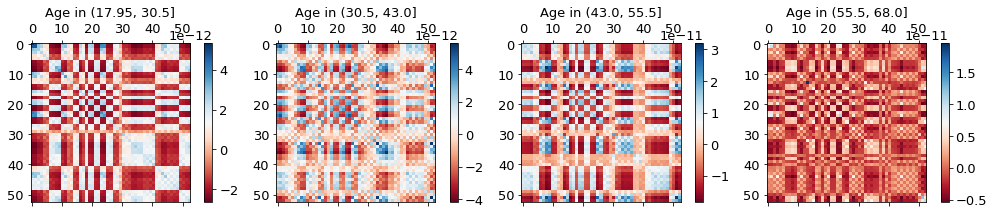

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

color = plt.cm.viridis(np.linspace(0.1, 0.9, 4))
fig, axes = plt.subplots(1, 4, figsize=(14, 9))
for ii, (key, inds) in enumerate(train_cases.groupby('age_group').groups.items()):
    im = axes[ii].matshow(X_covs[inds][1].mean(0), cmap='RdBu')
    axes[ii].set_title(f'Age in {key}')
    divider = make_axes_locatable(axes[ii])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(im, cax=cax)

fig.tight_layout()

What we see here suggests there is highly structured noise, this looks atypical. **If you see something like this please go back to your preprocessing work and figure out what causes it.**

# A more advanced model

Shall we still try to see if a more sophisticated model can do the job? Let's pretend we have not seen anything.

Now the idea is to first put all thes covariances in a data frame where things become easier to handle.

In [12]:
frequency_bands = {
    "theta": (4.0, 8.0),
    "alpha": (8.0, 15.0),
    "beta_low": (15.0, 26.0),
    "beta_high": (26.0, 35.0),
}

X_df = pd.DataFrame(
  {band: list(X_covs[:, ii]) for ii, band in enumerate(frequency_bands)})

In [13]:
X_df.shape

(199, 4)

In [14]:
X_df.columns

Index(['theta', 'alpha', 'beta_low', 'beta_high'], dtype='object')

In [15]:
X_df

,theta,alpha,beta_low,beta_high
0,"[[9.253301751571058e-12, 8.31307414294401e-12,...","[[1.359441473560296e-11, 1.113437502887364e-11...","[[3.0879667399053564e-12, 2.0339736749184162e-...","[[2.1921357814862212e-12, 1.4935337569369765e-..."
1,"[[4.249865002541282e-12, 3.900240055212897e-12...","[[1.352778930250213e-11, 1.1715759288507284e-1...","[[2.244400143918748e-12, 2.1496906832075234e-1...","[[1.4346702299833915e-12, 1.371637549130069e-1..."
2,"[[1.77545916229763e-11, 1.503842985629786e-11,...","[[1.5144442232845256e-11, 9.746412898822588e-1...","[[4.601417432047582e-12, 3.10749460989545e-12,...","[[2.5355439045856496e-12, 1.514508570768111e-1..."
3,"[[2.0842329510712477e-11, 2.134335984938621e-1...","[[6.307939971183569e-12, 5.9933168999047914e-1...","[[2.4580017989504238e-12, 2.21624499756571e-12...","[[6.430604991548031e-13, 4.916025706440751e-13..."
4,"[[3.033237749231775e-11, 2.8523254981257923e-1...","[[1.4375941111608865e-11, 1.1167324943849491e-...","[[2.485606582082101e-12, 1.6483376039866362e-1...","[[7.182520182965874e-13, 3.668047884758458e-13..."
...,...,...,...,...
194,"[[5.190696250865127e-12, 5.800103187496318e-12...","[[3.806466201887054e-12, 4.770854409093566e-12...","[[2.057818722739706e-12, 2.2393673627688136e-1...","[[5.710895178710288e-13, 6.183369728134512e-13..."
195,"[[1.5255216287075657e-11, 1.4988756209783463e-...","[[7.383552124639357e-12, 7.175966791853969e-12...","[[2.0038919849635332e-12, 1.7201334164041013e-...","[[7.864863287552666e-13, 7.300068215804419e-13..."
196,"[[7.494570758713223e-12, 6.539565031703325e-12...","[[4.598058046616944e-12, 3.5410559954670837e-1...","[[2.430341428088779e-12, 1.8403054050930294e-1...","[[1.0848870871163229e-12, 6.805722593461184e-1..."
197,"[[1.961321757938959e-11, 1.8393396939975187e-1...","[[1.4114360883749916e-11, 1.1291570939532615e-...","[[3.0136528970136133e-12, 2.3876488541999683e-...","[[9.64686905001567e-13, 7.227182210754544e-13,..."


Covariances in a Data Frame!

In [16]:
 y = train_cases.Age.values

In [17]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import coffeine

In [18]:
filter_bank_model = coffeine.make_filter_bank_regressor(names=['theta', 'alpha', 'beta_low', 'beta_high'])

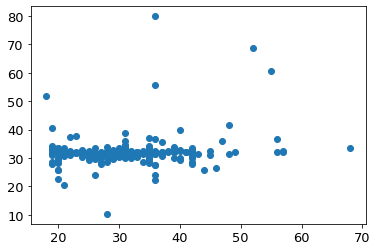

In [19]:
y_pred = cross_val_predict(estimator=filter_bank_model, X=X_df, y=y)
plt.scatter(y, y_pred)

In [20]:
from sklearn.metrics import r2_score
print(r2_score(y_true=y, y_pred=y_pred))

-0.2049128670205851


From a theoretical standpoint and empirically, this type of model is expected to work better. We can think a moment together about it. It is most likely that something is seriously wrong about the way we are using and processing the data, which can be very tricky when first encountering a new curated dataset. Something to be clarified in the nearer future; **But we're working on it together with the CHBM team**!